In [1]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import xml.etree.ElementTree as ET
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'
annotations_folder = 'dataset/ILSVRC/Annotations/CLS-LOC/'
synset_file = 'dataset/LOC_synset_mapping.txt'

In [2]:
f = open(synset_file,'r')
synset_lines = f.readlines()
f.close()
synset_dict = {}
for line in synset_lines:
    key = line.replace('\n','').split()[0]
    synset_dict[key] = line.replace('\n','').replace(key, '').strip()

In [3]:
image_classes = list(synset_dict.keys())

In [4]:
def get_annotations(xml_file):
    xml_root = ET.parse(xml_file).getroot()
    width = xml_root.find('size').find('width').text
    height = xml_root.find('size').find('height').text
    depth = xml_root.find('size').find('depth').text
    objects = xml_root.findall('object')
    name = objects[0].find('name').text
    bboxes = []
    for obj in objects:
        bbox = obj.find('bndbox')
        bboxes.append([int(bbox.find('xmin').text), 
                       int(bbox.find('ymin').text),
                       int(bbox.find('xmax').text),
                       int(bbox.find('ymax').text)])
    filename = xml_root.find('filename').text
    return int(width), int(height), int(depth), bboxes, filename, name

In [5]:
def get_class_xml_files(img_class, dataset='train'):
    xml_class_files = glob.glob(annotations_folder+dataset+'/'+img_class+'/'+'*.xml')
    return xml_class_files

In [6]:
def create_dict(img_class, annotations_dict, dataset='train'):
    xml_class_files = get_class_xml_files(img_class, dataset)
    for xml_file in xml_class_files:
        width, height, depth, bboxes, filename, name = get_annotations(xml_file)
        if img_class not in annotations_dict:
            annotations_dict[img_class] = {}
        annotations_dict[img_class][filename] = {}
        annotations_dict[img_class][filename]['width'] = width
        annotations_dict[img_class][filename]['height'] = height
        annotations_dict[img_class][filename]['depth'] = depth
        annotations_dict[img_class][filename]['bounding_boxes'] = bboxes

In [7]:
dataset = 'train'
annotations_dict = {}
for img_class in image_classes:
    create_dict(img_class, annotations_dict, dataset)

In [10]:
np.save('annotations_train.npy', annotations_dict)

In [11]:
len(list(annotations_dict.keys()))

1000

In [12]:
def get_val_annotations(annotations_dict):
    for filename in glob.glob(annotations_folder+'val'+'/'+'*.xml'):
        width, height, depth, bboxes, filename, img_class = get_annotations(filename)
        if img_class not in annotations_dict:
            annotations_dict[img_class] = {}
        annotations_dict[img_class][filename] = {}
        annotations_dict[img_class][filename]['width'] = width
        annotations_dict[img_class][filename]['height'] = height
        annotations_dict[img_class][filename]['depth'] = depth
        annotations_dict[img_class][filename]['bounding_boxes'] = bboxes
    return

In [13]:
annotations_val_dict = {}
get_val_annotations(annotations_val_dict)

In [15]:
np.save('annotations_val.npy', annotations_val_dict)

In [14]:
len(list(annotations_val_dict.keys()))

1000

In [70]:
def get_selected_dict(final_selection, annotations_dict):
    selection_dict = {}
    heights = []
    for img_class in final_selection:
        selection_dict[img_class] = {}
        for k, v in annotations_dict[img_class].items():
            if len(v['bounding_boxes']) == 1 and v['width'] == 500 and v['depth'] == 3 and v['height'] == 375:
                selection_dict[img_class][k] = v
                heights.append(v['height'])
    return selection_dict

In [12]:
sel_classes = ['n04487081', 'n07873807', 'n02321529', 'n07711569', 'n01817953', 'n02108089', 'n01751748', 'n02701002', 'n02279972', 'n03977966']

In [71]:
sel_dic = get_selected_dict(sel_classes, annotations_val_dict)

In [72]:
np.save('reduced_dataset/annotations_val.npy', sel_dic)

In [73]:
s = 0
for img_class in sel_classes:
    s = s + len(list(sel_dic[img_class].keys()))
    print(len(list(sel_dic[img_class].keys())))

31
23
13
11
8
26
33
39
30
23


n04487081
trolleybus, trolley coach, trackless trolley
31
ILSVRC2012_val_00026497
ILSVRC2012_val_00006998
ILSVRC2012_val_00027480
ILSVRC2012_val_00000795
ILSVRC2012_val_00032183
ILSVRC2012_val_00008004
ILSVRC2012_val_00011148
ILSVRC2012_val_00041413
ILSVRC2012_val_00049241
ILSVRC2012_val_00005140
ILSVRC2012_val_00042445
ILSVRC2012_val_00033342
ILSVRC2012_val_00002146
ILSVRC2012_val_00004090
ILSVRC2012_val_00034724
ILSVRC2012_val_00034640


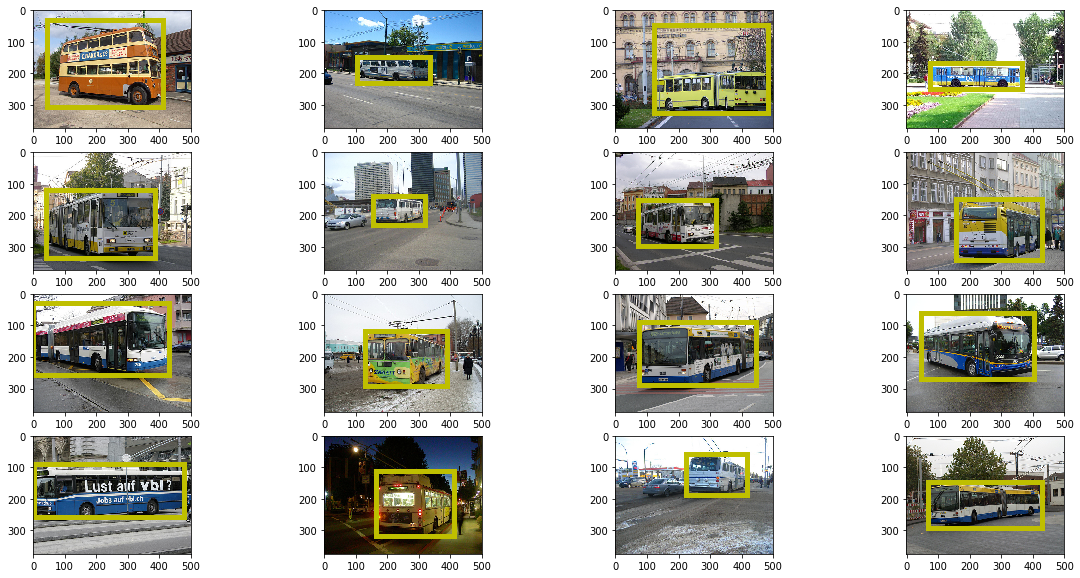

In [76]:
img_class = sel_classes[0]
print(img_class)
print(synset_dict[img_class])
image_filenames = list(sel_dic[img_class].keys())
print(len(image_filenames))

fig, axs = plt.subplots(4,4, figsize=(20,10))
axs = axs.flatten()
for i, image_file_id in enumerate(image_filenames[:16]):
    print(image_file_id)
    #image_file = data_folder+'/train/'+img_class+'/' +image_file_id+'.JPEG'
    image_file = data_folder+'/val/' +image_file_id+'.JPEG'
    image = Image.open(image_file)
    axs[i].imshow(image)
    bounding_box = sel_dic[img_class][image_file_id]['bounding_boxes'][0]

    rect = patches.Rectangle(bounding_box[:2],bounding_box[2]-bounding_box[0],bounding_box[3]-bounding_box[1],linewidth=5, edgecolor='y',facecolor='none')
    axs[i].add_patch(rect)
plt.show()